# Image Classification with CIFAR-10 dataset
In this Deep Learning project, We are going to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.


## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


### Understanding the original data 

The original a batch data is (10000 x 3072) dimensional tensor expressed in numpy array, where the number of columns, (10000), indicates the number of sample data. As stated in the [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), the row vector, (3072) represents an color image of 32x32 pixels. Since this project is going to use CNN for the classification tasks, the row vector, (3072), is not an appropriate form of image data to feed. In order to feed an image data into a CNN model, the dimension of the tensor representing an image data should be either (width x height x num_channel) or (num_channel x width x height). It depends on your choice (check out the [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)). In this particular project, we are going to use the dimension of the first choice because the default choice in tensorflow's CNN operation is so.


### Understanding the original labels

The label data is just a list of 10000 numbers in the range 0-9, which corresponds to each of the 10 classes in CIFAR-10. 

* **airplane**
* **automobile**
* **bird**
* **cat**
* **deer**
* **dog**
* **frog**
* **horse**
* **ship**
* **truck**


In [2]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### How to reshape into a such form?

The row vector (3072) has the exact same number of elements if you calculate 32\*32\*3==3072. In order to reshape the row vector, (3072), there are two steps required. The **first** step is involved with using **reshape** function in numpy, and the **second** step is involved with using **transpose** function in numpy as well.

By definition from the official web site, **reshape** function gives a new shape to an array without changing its data. Here, the phrase **without changing its data** is an important part. **reshape** operations should be delivered in three more detailed step. The following direction is described in a logical concept. 

1. divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
  - this results in (3 x 1024) dimension of tensor
2. divide the resulting tensor from the previous step with 32. 32 here means width of an image.
  - this results in (3 x 32 x 32)

In order to implement the directions written in logical sense in numpy, **reshape** function should be called in the following arguments, (10000, 3, 32, 32). As you noticed, reshape function doesn't automatically divide further when the third value (32, width) is provided. We need to explicitly specify the value for the last value (32, height)


This is not the end of story. Now, the image data is represented as (num_channel, width, height) form. However, **this is not the shape tensorflow and matplotlib are expecting**. They are expecting different shape of (width, height, num_channel) instead. We need to swap the order of each axes, and that is where **transpose** function comes in.

The **transpose** function can take a list of axes, and each value specifies where it wants to move around. For example, calling transpose with argument (1, 2, 0) in an numpy array of (num_channel, width, height) will return a new numpy array of (width, height, num_channel).

<img src="./reshape-transpose.png" alt="Drawing" style="width: 800px;"/>

In [3]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Explore the Data

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

The display_stats defined below answers some of questions like in a given batch of data..
- "What are all possible labels?"
- "What is the range of values for the image data?"
- "Are the labels in order or random?"


In [4]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


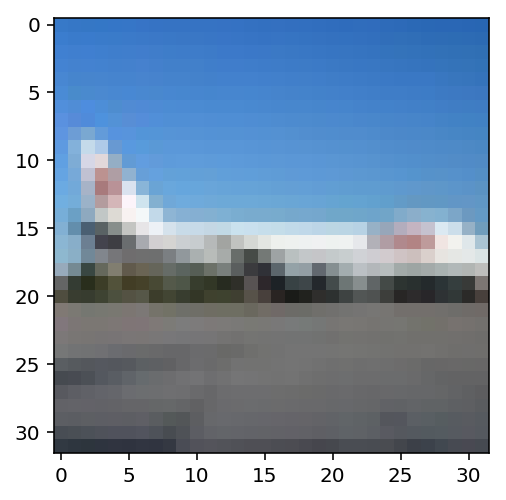

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
**Min-Max Normalization**
- this simply makes all x values to range between 0 and 1.
- y = (x-min) / (max-min)

`normalize` function takes an image data, `x`, and returns it as a normalized Numpy array. The values in the original data is going to be transformed in range of 0 to 1, inclusive without change the shape of the array. A simply answer to why normalization should be performed is somewhat related to activation function.

For example, sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarily, when the input value is somewhat small, the output value easily reaches the max value 0. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/480px-Logistic-curve.svg.png" alt="Drawing" style="width: 300px;"/>

For another example, ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. When the input value is somewhat large, the output value increases linearly. However, when the input value is somewhat small, the output value easily reaches the max value 0. 

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_4/Relu.jpeg" alt="Drawing" style="width: 300px;"/>

Now, when we think about the image data, all values originally ranges from 0 to 255. This sounds like when it is passed into sigmoid function, the output is almost always 1, and when it is passed into ReLu function, the output could be very huge. When backpropagation process is performed to optimize the networks, this could lead to an exploding gradient which leads to an aweful learning steps. In order to avoid this issue, ideally, it is better let all the values be around 0 and 1.

In [6]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

### One-hot encode

Since the output of our model is going to show the probabilities of where an image should be categorized as a prediction. There should be a vector having the same number of elements as the number of image classes. For instance, CIFAR-10 provides 10 different classes of image, so we need a vector in size of 10 as well. Each element represents the predicting probability of each classes.

Also, our model should be able to compare the prediction with the ground truth label. It means the shape of the label data should also be transformed into a vector in size of 10 too. Instead, because label is the ground truth, we set the value 1 to the corresponding element.

**`one_hot_encode`** function takes the input, **`x`**, which is a list of labels(ground truth). The total number of element in the list is the total number of samples in a batch. **`one_hot_encode`** function returns a 2 dimensional tensor, where the number of row is the size of the batch, and the number of column is the number of image classes.


In [7]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

## Preprocess all the data and save it

The code cell below uses the previously implemented functions, normalize and one_hot_encode, to preprocess the given dataset.
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation. 

<img src="./train-valid-test split.png" alt="Drawing" style="width: 700px;"/>

In [8]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whole dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [9]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [10]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Tensorflow Basic

Before diving in building the network and training process, it is good to remind ourselved how Tensorflow works. 


### Tensorflow Workflow

According to the official document, **TensorFlow** uses a **dataflow graph** to represent your computation in terms of the dependencies between individual operations. This leads to a low-level programming model in which you **first define the dataflow graph**, **then** create a TensorFlow **session to run parts of the graph** across a set of local and remote devices.

**Dataflow** is a common programming model for **parallel computing**. In a dataflow graph, the nodes represent units of computation, and the edges represent the data consumed or produced by a computation. For example, in a TensorFlow graph, the tf.matmul operation would correspond to a single node with two incoming edges (the matrices to be multiplied) and one outgoing edge (the result of the multiplication).

Most **TensorFlow** programs **start with a dataflow graph construction phase**. In this phase, you invoke TensorFlow API functions that construct new tf.Operation (node) and tf.Tensor (edge) objects and add them to a tf.Graph instance. **TensorFlow provides a default graph** that is an **implicit argument to all API functions in the same context**.

The **tf.Session.run method** is the main mechanism for **running a tf.Operation or evaluating a tf.Tensor**. You can pass one or more tf.Operation or tf.Tensor objects to tf.Session.run, and TensorFlow will execute the operations that are needed to compute the result.

<img src="https://www.tensorflow.org/versions/r1.3/images/tensors_flowing.gif" alt="Drawing" style="width: 300px;"/>


## Build the network

The image below depicts what the model would look like in this notebook.

<img src="./conv_model.png" alt="Drawing" style="width: 1000px;"/>

In [11]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Create Convolutional Model

The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

1. Convolution with 64 different filters in size of (3x3)
2. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
3. Convolution with 128 different filters in size of (3x3)
4. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
5. Convolution with 256 different filters in size of (3x3)
6. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
7. Convolution with 512 different filters in size of (3x3)
8. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
9. Flattening the 3-D output of the last convolutional operations.
10. Fully Connected Layer with 128 units
  - Dropout 
  - Batch Normalization
11. Fully Connected Layer with 256 units
  - Dropout 
  - Batch Normalization
12. Fully Connected Layer with 512 units
  - Dropout 
  - Batch Normalization
13. Fully Connected Layer with 1024 units
  - Dropout 
  - Batch Normalization
14. Fully Connected Layer with 10 units (number of image classes)

the image below decribes how the conceptual convolving operation differs from the tensorflow implementation when you use [Channel x Width x Height] tensor format. 

<img src="./convolving.png" alt="Drawing" style="width: 1000px;"/>


### Building the convolutional Layers
When building a convolutional layer, there are three things to consider. That is the stride, padding, and filter.

#### Filter
A tensor of 3 dimensions that has the weights and convolutes over the input tensors.

#### Strides
The stride determines how much the window of filter should be moved for every convolving steps, and it is a 1-D tensor of length 4.
Example
Lets take a tensor of a grayscale image
00 01 02 03 ....
10 11 12 13 ....
20 21 22 23 ....

A stride of [1,1,1,1] with a filter of [2x2] means that the filter will cover
````
[ 00 01
  10 11
]
in its first iteration and then 
[ 01 02
  11 12
]
in the second and after the end of first row
[ 10 11
  20 21 
]
and so on
````
stride[0]: No of examples to skip

stride[3]: No of depth to skip

These should be 1 because we don't want to skip any of our data, otherwise we shouldn't have included that in the first place.

#### Padding
Consider an input tensor - [1,2,3,4,5]

Filter: [4,1,1]

Stride: [1,3,1,1]

Tensorflow provides two types of paddings
* VALID
````
    Output: [1,2,3,4]
    [5] will be dropped
````
* SAME
````
    Output: [1,2,3,4 |  4,5,0,0]
    [0,0] will be padded at the end
````

We will use SAME padding as it will ensure same size of the image after convolution.

#### Max-Pooling
Max-Pooling can be considered as a special type of convolution, except it doesn't have weights. The purpose is to shrink the image by letting the strongest value survived. ksize=[1,2,2,1] and strides=[1,2,2,1] will shrink the image into half size.

In [12]:
import tensorflow as tf

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

### Hyperparameters

* `epochs`: number of iterations until the network stops learning or start overfitting
* `batch_size`: highest number that your machine has memory for.  Most people set them to common sizes of memory:
* `keep_probability`: probability of keeping a node using dropout
* `learning_rate`: number how fast the model learns

In [13]:
epochs = 8
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

### Cost Function & Optimizer
* **Logits:** A vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class.


* **Cost:** This is the reduced mean between the softmax (normalized) logits calculated by the network that we designed and the actual output class. The output classes are also one-hot encoded, where the actual class has a probalility of 1 and other have a probability of 0.
- tf.reduce_mean returns => The reduced **Tensor**

* **Optimizer Algorithm (Adam Optimizer):** Unlike Stochastic gradient descent where the learning rate does not change during training, in case of AdamOptimizer, the learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.
- tf.train.AdamOptimizer returns => An **Operation** that applies the specified gradients.

![Optimizer Comparison](optimizers.png)

* **Accuracy**
  * We compare the index of max value of logits for each example with the actual output. If they are same, then the image is correctly classified, else the prediction was wrong.
  * We take a mean of all these correct predictions to find the accuracy of the batch.
  - tf.reduce_mean returns => The reduced **Tensor**


In [14]:
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Train the Neural Network


tf.Session.run method in the official document explains it runs one "step" of TensorFlow computation, by running the necessary graph fragment to execute every Operation and evaluate every Tensor in fetches, substituting the values in feed_dict for the corresponding input values. The fetches argument may be a single graph element, or an arbitrarily nested list, tuple, etc.

Here what graph element really is tf.Tensor or tf.Operation. Cost, Optimizer, and Accuracy are one of those types meaning they can be specified as part of the fetches argument. Then, we can feed some variables along the way. This is kind of handy feature of Tensorflow. Once we have constructed the graph, all we need to do is feeding data into that graph and specifying what results to retrieve.


### Single Optimization


In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

### Show Stats


In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [18]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

## Save the model to disk:

In [19]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2422 Validation Accuracy: 0.189200
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.9453 Validation Accuracy: 0.168200
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.7581 Validation Accuracy: 0.234000
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.8107 Validation Accuracy: 0.278600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.6703 Validation Accuracy: 0.284800
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8224 Validation Accuracy: 0.300800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.6462 Validation Accuracy: 0.325600
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.4319 Validation Accuracy: 0.380000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.4851 Validation Accuracy: 0.428000
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.2391 Validation Accuracy: 0.483600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.0452 Validation Accuracy: 0.528600
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.0010 Validation Accuracy: 0.559200
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.7582 Validation Accuracy: 0.589800


## Test Model

In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7323845541401274



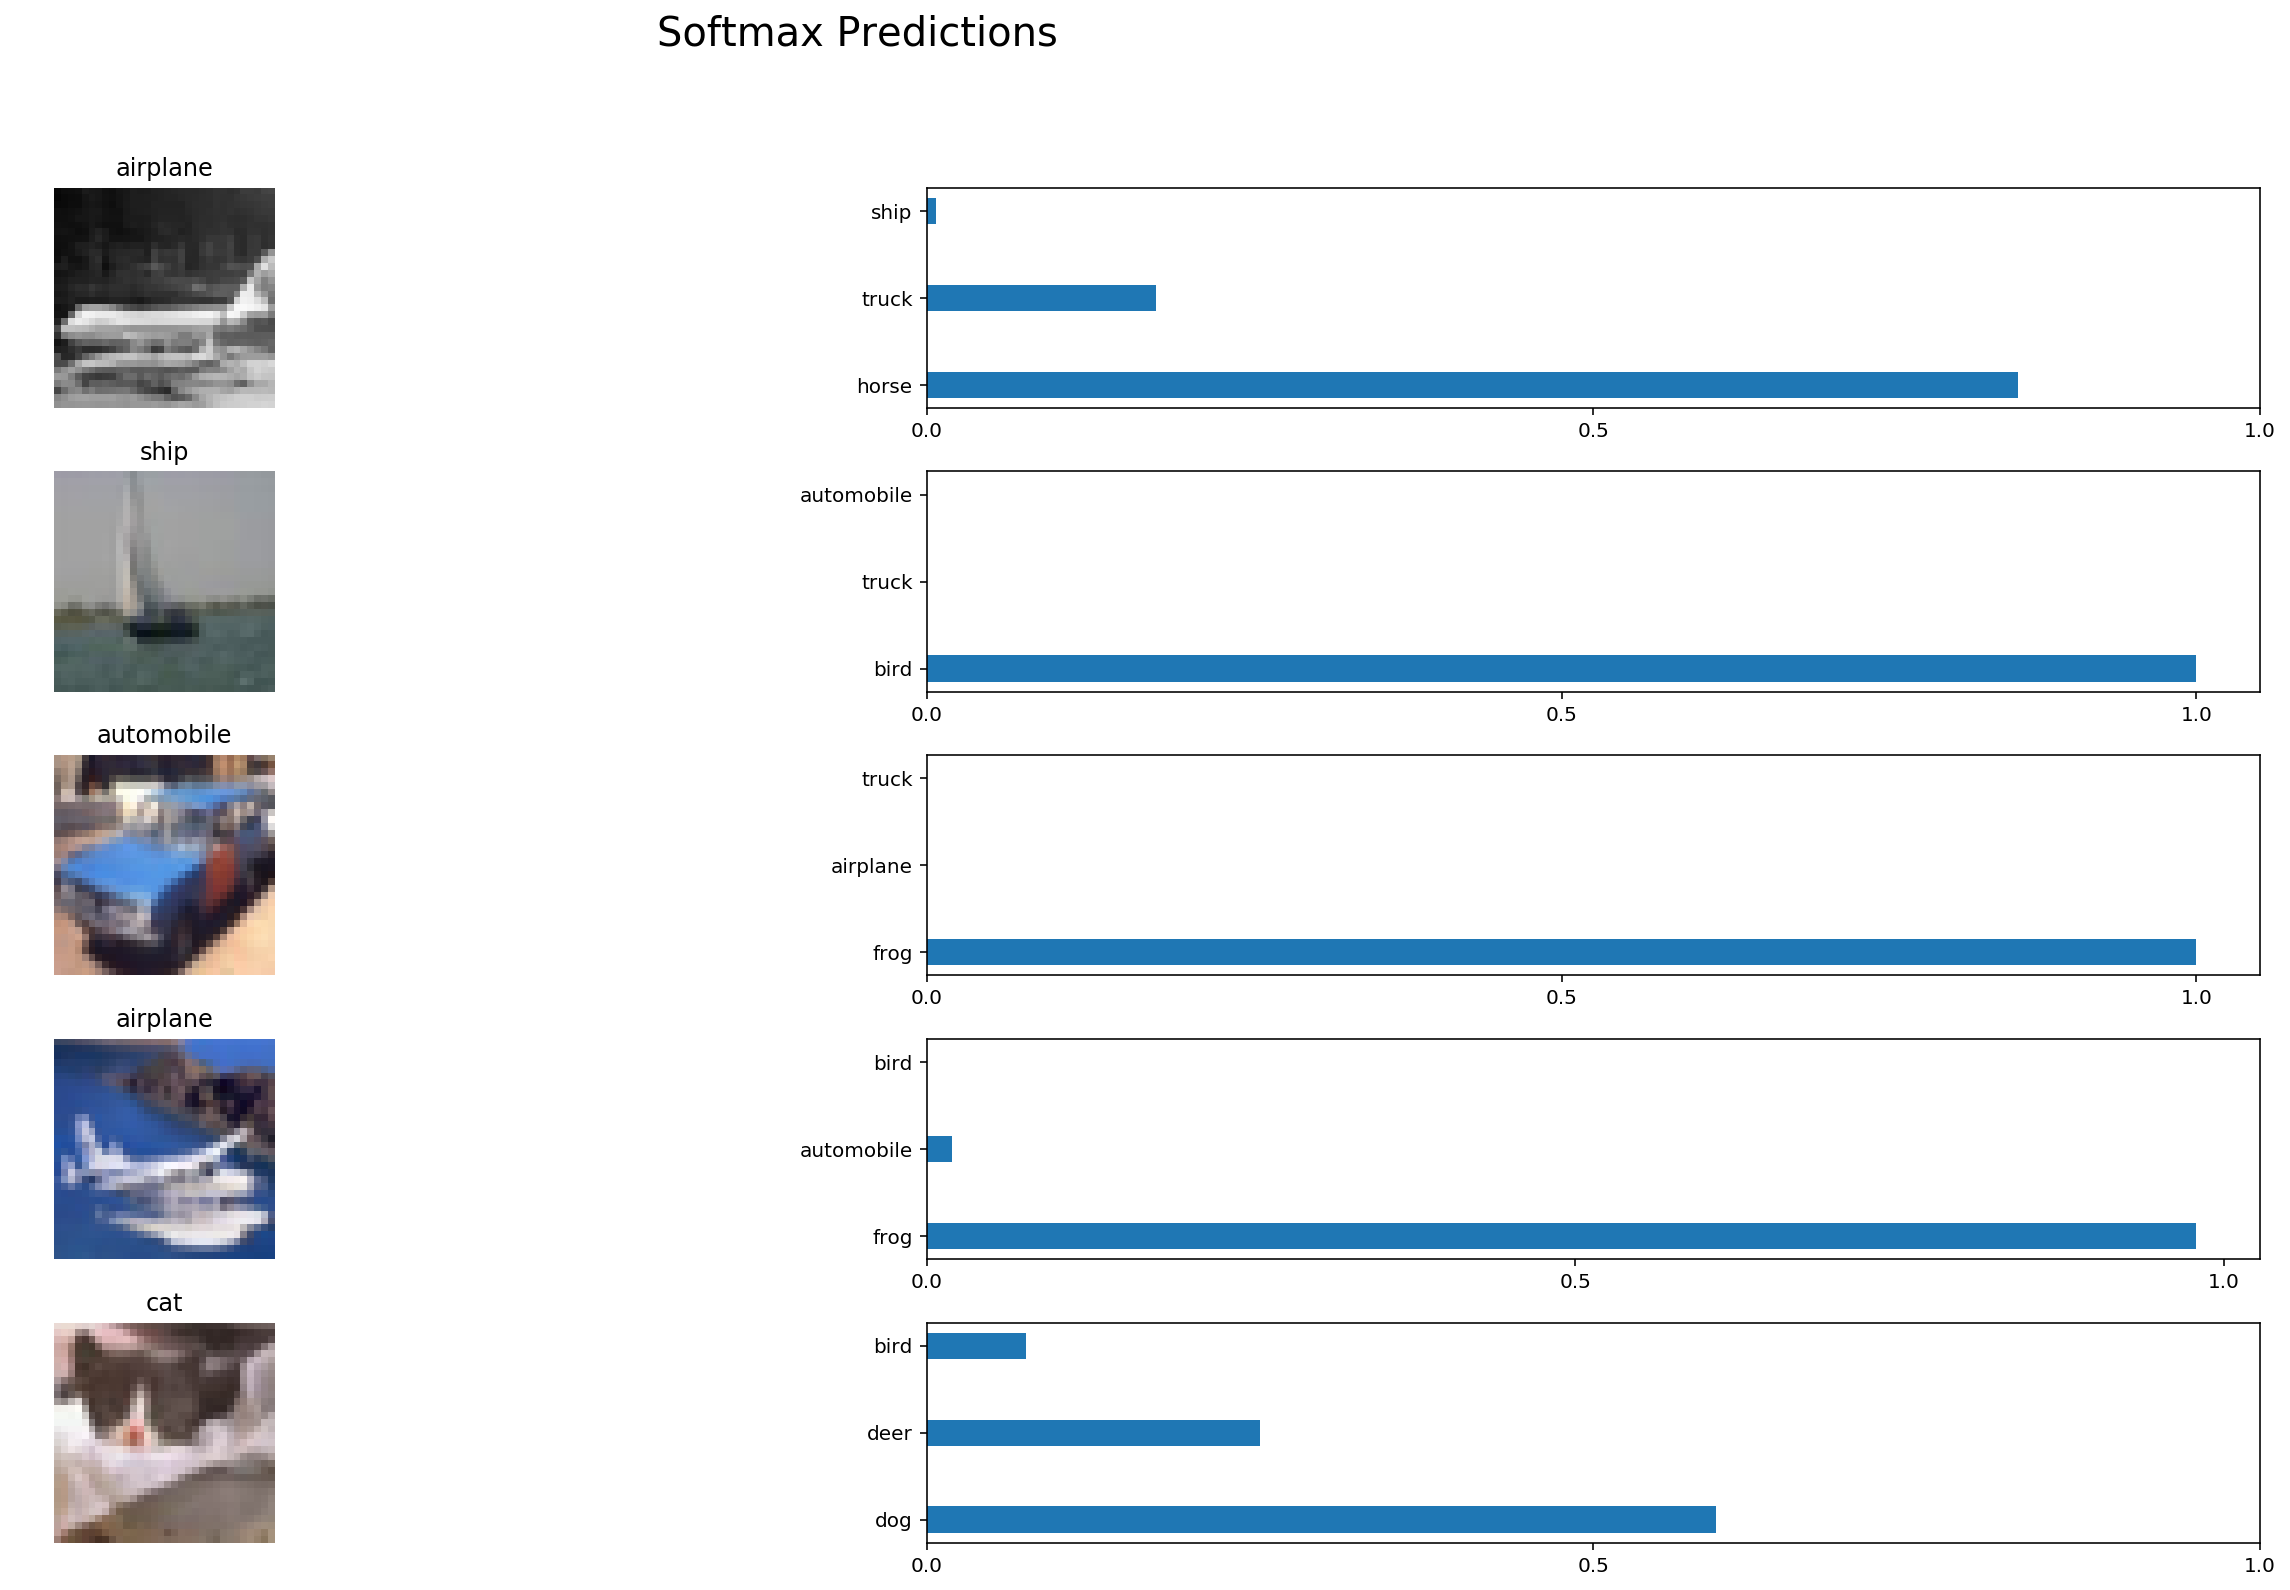

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)


test_model()

![Validation Accuracy & Loss VS Epochs](Valid_Acc_Loss.png)

The above chart shows the change in loss and validation accuracy (when batch-1 is used for training) as the number of epochs increases.
The classifier has managed to achieve a loss of 1.11% and a validation accuracy of 72.98%


#### References to look up
- [Tensorflow Architecture](https://www.tensorflow.org/extend/architecture)
- [Tensorflow Conv2D under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)
- [Tensorflow ReLU under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/relu)
- [Tensorflow Max Pooling under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)
- [Tensorflow Dropout under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)
- [Tensorflow Flatten under tf.contrib](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)
- [Tensorflow Fully Connected under tf.contrib](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)
- [Batch Normalization (the original paper)](https://arxiv.org/abs/1502.03167)
- [Why does Batch Norm works? / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=NbGUU6ZYtus)
- [Understanding Dropout / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=ARq74QuavAo)
- [Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)
- [What is the meaning of flattening step in a convolutional neural network?](https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network)
- [Convolutional Neural Networks (CNNs / ConvNets) - CS231n](http://cs231n.github.io/convolutional-networks/)
- [Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)
- [Evaluation of the CNN design choices performance on ImageNet-2012](https://github.com/ducha-aiki/caffenet-benchmark)
- [Tensorflow Session run function](https://www.tensorflow.org/api_docs/python/tf/Session#run)
- [Tensorflow tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)
- [Tensorflow tf.train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)
- [Tensorflow Softmax Cross Entropy with Logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2)
- [Tensorflow Optimizers](https://www.tensorflow.org/api_guides/python/train)
